In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
TESTED_MODES = np.arange(1, 33, dtype=int)
TRAIN_SPLIT = 2/3

In [3]:
np.random.seed(42)

In [4]:
collision_file = np.load(".data/Time_series_colisao.npz")
display(collision_file)
spreading_file = np.load(".data/Time_series_espalhamento.npz")
display(spreading_file)

NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B

NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...

In [5]:
collision_timesteps_raw = collision_file['TS']
display(f"Dimensions of the collision simulations: {collision_timesteps_raw.shape}")
display(f"That is, {collision_timesteps_raw.shape[0]} simulations, with {collision_timesteps_raw.shape[1]} timesteps each, having {collision_timesteps_raw.shape[2]} components each.")
spreading_timesteps_raw = spreading_file['TS']
display(f"Dimensions of the spreading simulations: {spreading_timesteps_raw.shape}")
display(f"That is, {spreading_timesteps_raw.shape[0]} simulations, with {spreading_timesteps_raw.shape[1]} timesteps each, having {spreading_timesteps_raw.shape[2]} components each.")

'Dimensions of the collision simulations: (72, 1000, 5)'

'That is, 72 simulations, with 1000 timesteps each, having 5 components each.'

'Dimensions of the spreading simulations: (132, 1000, 4)'

'That is, 132 simulations, with 1000 timesteps each, having 4 components each.'

# Collision component-wise order reduction

## Reordering data

We want to avoid mixing components in this case

In [6]:
components_names = ['Diameter', 'Height', 'Kinetic Energy', 'Surface Energy', 'Dissipative Energy']
collision = dict()
for i, cn in enumerate(components_names):
    cn_dict = {}
    cn_dict['original_data'] = collision_timesteps_raw[:, :, i].T
    # (n_simulations, timesteps) [RAW]
    # (timesteps, n_simulations) [.T]
    collision[cn] = cn_dict

## Scaling

Firstly, we want to remove the "temporal mean", that is, the mean for each simulation of each component. After that, we can also scale the data so its standard variation is equal to 1:

$$\pmb{\hat{X}}=\sqrt{\frac{1}{n}}\left(\pmb{X}-\hat{x}1\right)$$

In [7]:
from sklearn.preprocessing import StandardScaler

for key, obj in collision.items():
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(obj['original_data'])
    display(f"Asserting mean = 0 and std = 1 for component '{key}'")
    assert np.allclose(scaled_data.mean(axis=0), 0)
    assert np.allclose(scaled_data.std(axis=0), 1)
    display("Success!")
    obj['scaled_data'] = scaled_data
    obj['scaler'] = scaler

"Asserting mean = 0 and std = 1 for component 'Diameter'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Height'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Kinetic Energy'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Surface Energy'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Dissipative Energy'"

'Success!'

## Testing for all the given modes

In [8]:
from sklearn.decomposition import PCA

NUMBER_OF_MODES = TESTED_MODES.shape[0]
for key, obj in collision.items():
    number_of_timesteps = obj['scaled_data'].shape[0]
    permutation_idx = np.random.permutation(number_of_timesteps)
    training_size = int(TRAIN_SPLIT * number_of_timesteps)
    training_idx = permutation_idx[:training_size]
    testing_idx = permutation_idx[training_size:]
    training_data = obj['original_data'][training_idx]
    training_data_scaled = obj['scaled_data'][training_idx]
    testing_data = obj['original_data'][testing_idx]
    testing_data_scaled = obj['scaled_data'][testing_idx]
    modes_mse = np.zeros((number_of_timesteps, NUMBER_OF_MODES))
    modes_mae = np.zeros_like(modes_mse)
    modes_mrae = np.zeros_like(modes_mse)
    for i, mode in enumerate(TESTED_MODES):
        # TRAINING DATA
        pca = PCA(n_components=mode, random_state=42)
        pca.fit(training_data_scaled)
        reconstructed_training_scaled = pca.inverse_transform(pca.transform(training_data_scaled))
        reconstructed_training = obj['scaler'].inverse_transform(reconstructed_training_scaled)
        mse_training = np.mean((training_data - reconstructed_training)**2, axis=1)
        mae_training = np.mean(np.abs(training_data - reconstructed_training), axis=1)
        mrae_training = np.mean(np.abs(training_data - reconstructed_training) / np.abs(training_data), axis=1)
        # TESTING DATA
        reconstructed_testing_scaled = pca.inverse_transform(pca.transform(testing_data_scaled))
        reconstructed_testing = obj['scaler'].inverse_transform(reconstructed_testing_scaled)
        mse_testing = np.mean((testing_data - reconstructed_testing)**2, axis=1)
        mae_testing = np.mean(np.abs(testing_data - reconstructed_testing), axis=1)
        mrae_testing = np.mean(np.abs(testing_data - reconstructed_testing) / np.abs(testing_data), axis=1)
        # STORING DATA
        modes_mse[training_idx, i] = mse_training
        modes_mae[training_idx, i] = mae_training
        modes_mrae[training_idx, i] = mrae_training
        modes_mse[testing_idx, i] = mse_testing
        modes_mae[testing_idx, i] = mae_testing
        modes_mrae[testing_idx, i] = mrae_testing
    training_error_idx = pd.Index(training_idx, name='Timestep')
    testing_error_idx = pd.Index(testing_idx, name='Timestep')
    columns = pd.MultiIndex.from_product([TESTED_MODES, ['MSE', 'MAE', 'MRAE']], names=['Modes', 'Metric'])
    training_error_data = np.zeros((training_error_idx.shape[0], NUMBER_OF_MODES * 3))
    testing_error_data = np.zeros((testing_error_idx.shape[0], NUMBER_OF_MODES * 3))
    training_error_data[:, ::3] = modes_mse[training_idx]
    training_error_data[:, 1::3] = modes_mae[training_idx]
    training_error_data[:, 2::3] = modes_mrae[training_idx]
    testing_error_data[:, ::3] = modes_mse[testing_idx]
    testing_error_data[:, 1::3] = modes_mae[testing_idx]
    testing_error_data[:, 2::3] = modes_mrae[testing_idx]
    training_error_df = pd.DataFrame(training_error_data, columns=columns, index=training_error_idx).sort_index()
    testing_error_df = pd.DataFrame(testing_error_data, columns=columns, index=testing_error_idx).sort_index()
    obj['permutation_idx'] = permutation_idx
    obj['training_idx'] = training_idx
    obj['testing_idx'] = testing_idx
    obj['training_error'] = training_error_df
    obj['testing_error'] = testing_error_df

## Showing these errors in graphs

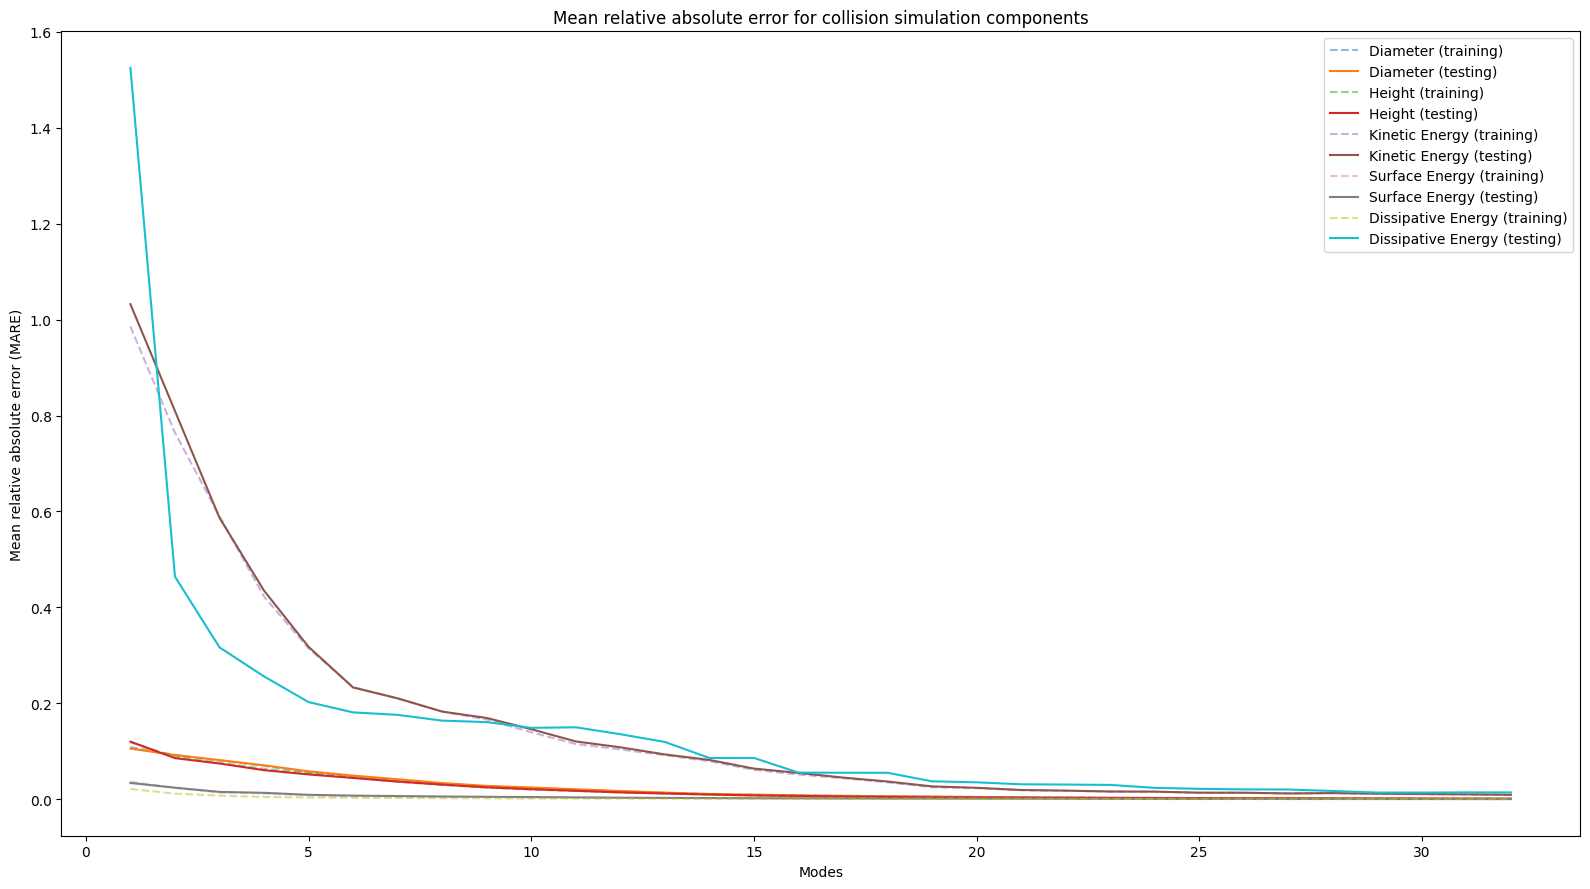

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Mean relative absolute error for collision simulation components")
ax.set_xlabel("Number of modes")
ax.set_ylabel("Mean relative absolute error (MARE)")

for key, obj in collision.items():
    obj['training_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='--', alpha=0.5)
    obj['testing_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='-')

training_legend = [f"{key} (training)" for key in collision.keys()]
testing_legend = [f"{key} (testing)" for key in collision.keys()]
legend = [''] * (len(training_legend) + len(testing_legend))
legend[::2] = training_legend
legend[1::2] = testing_legend
ax.legend(legend)
fig.tight_layout()
fig.savefig(f".results/pca_error_modes_collision.png", dpi=200)
plt.show()

# Spreading component-wise order reduction

## Reordering data

We want to avoid mixing components in this case

In [10]:
spreading_components_names = ['Diameter', 'Kinetic Energy', 'Surface Energy', 'Dissipative Energy']
spreading = dict()
for i, cn in enumerate(spreading_components_names):
    cn_dict = {}
    cn_dict['original_data'] = spreading_timesteps_raw[:, :, i].T
    # (n_simulations, timesteps) [RAW]
    # (timesteps, n_simulations) [.T]
    spreading[cn] = cn_dict

## Scaling

Firstly, we want to remove the "temporal mean", that is, the mean for each simulation of each component. After that, we can also scale the data so its standard variation is equal to 1:

$$\pmb{\hat{X}}=\sqrt{\frac{1}{n}}\left(\pmb{X}-\hat{x}1\right)$$

In [11]:
from sklearn.preprocessing import StandardScaler

for key, obj in spreading.items():
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(obj['original_data'])
    display(f"Asserting mean = 0 and std = 1 for component '{key}'")
    assert np.allclose(scaled_data.mean(axis=0), 0)
    assert np.allclose(scaled_data.std(axis=0), 1)
    display("Success!")
    obj['scaled_data'] = scaled_data
    obj['scaler'] = scaler

"Asserting mean = 0 and std = 1 for component 'Diameter'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Kinetic Energy'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Surface Energy'"

'Success!'

"Asserting mean = 0 and std = 1 for component 'Dissipative Energy'"

'Success!'

## Testing for all the given modes

In [12]:
from sklearn.decomposition import PCA

NUMBER_OF_MODES = TESTED_MODES.shape[0]
for key, obj in spreading.items():
    number_of_timesteps = obj['scaled_data'].shape[0]
    permutation_idx = np.random.permutation(number_of_timesteps)
    training_size = int(TRAIN_SPLIT * number_of_timesteps)
    training_idx = permutation_idx[:training_size]
    testing_idx = permutation_idx[training_size:]
    training_data = obj['original_data'][training_idx]
    training_data_scaled = obj['scaled_data'][training_idx]
    testing_data = obj['original_data'][testing_idx]
    testing_data_scaled = obj['scaled_data'][testing_idx]
    modes_mse = np.zeros((number_of_timesteps, NUMBER_OF_MODES))
    modes_mae = np.zeros_like(modes_mse)
    modes_mrae = np.zeros_like(modes_mse)
    for i, mode in enumerate(TESTED_MODES):
        # TRAINING DATA
        pca = PCA(n_components=mode)
        pca.fit(training_data_scaled)
        reconstructed_training_scaled = pca.inverse_transform(pca.transform(training_data_scaled))
        reconstructed_training = obj['scaler'].inverse_transform(reconstructed_training_scaled)
        mse_training = np.mean((training_data - reconstructed_training)**2, axis=1)
        mae_training = np.mean(np.abs(training_data - reconstructed_training), axis=1)
        mrae_training = np.mean(np.abs(training_data - reconstructed_training) / np.abs(training_data), axis=1)
        # TESTING DATA
        reconstructed_testing_scaled = pca.inverse_transform(pca.transform(testing_data_scaled))
        reconstructed_testing = obj['scaler'].inverse_transform(reconstructed_testing_scaled)
        mse_testing = np.mean((testing_data - reconstructed_testing)**2, axis=1)
        mae_testing = np.mean(np.abs(testing_data - reconstructed_testing), axis=1)
        mrae_testing = np.mean(np.abs(testing_data - reconstructed_testing) / np.abs(testing_data), axis=1)
        # STORING DATA
        modes_mse[training_idx, i] = mse_training
        modes_mae[training_idx, i] = mae_training
        modes_mrae[training_idx, i] = mrae_training
        modes_mse[testing_idx, i] = mse_testing
        modes_mae[testing_idx, i] = mae_testing
        modes_mrae[testing_idx, i] = mrae_testing
    training_error_idx = pd.Index(training_idx, name='Timestep')
    testing_error_idx = pd.Index(testing_idx, name='Timestep')
    columns = pd.MultiIndex.from_product([TESTED_MODES, ['MSE', 'MAE', 'MRAE']], names=['Modes', 'Metric'])
    training_error_data = np.zeros((training_error_idx.shape[0], NUMBER_OF_MODES * 3))
    testing_error_data = np.zeros((testing_error_idx.shape[0], NUMBER_OF_MODES * 3))
    training_error_data[:, ::3] = modes_mse[training_idx]
    training_error_data[:, 1::3] = modes_mae[training_idx]
    training_error_data[:, 2::3] = modes_mrae[training_idx]
    testing_error_data[:, ::3] = modes_mse[testing_idx]
    testing_error_data[:, 1::3] = modes_mae[testing_idx]
    testing_error_data[:, 2::3] = modes_mrae[testing_idx]
    training_error_df = pd.DataFrame(training_error_data, columns=columns, index=training_error_idx).sort_index()
    testing_error_df = pd.DataFrame(testing_error_data, columns=columns, index=testing_error_idx).sort_index()
    obj['permutation_idx'] = permutation_idx
    obj['training_idx'] = training_idx
    obj['testing_idx'] = testing_idx
    obj['training_error'] = training_error_df
    obj['testing_error'] = testing_error_df

## Showing these errors in graphs

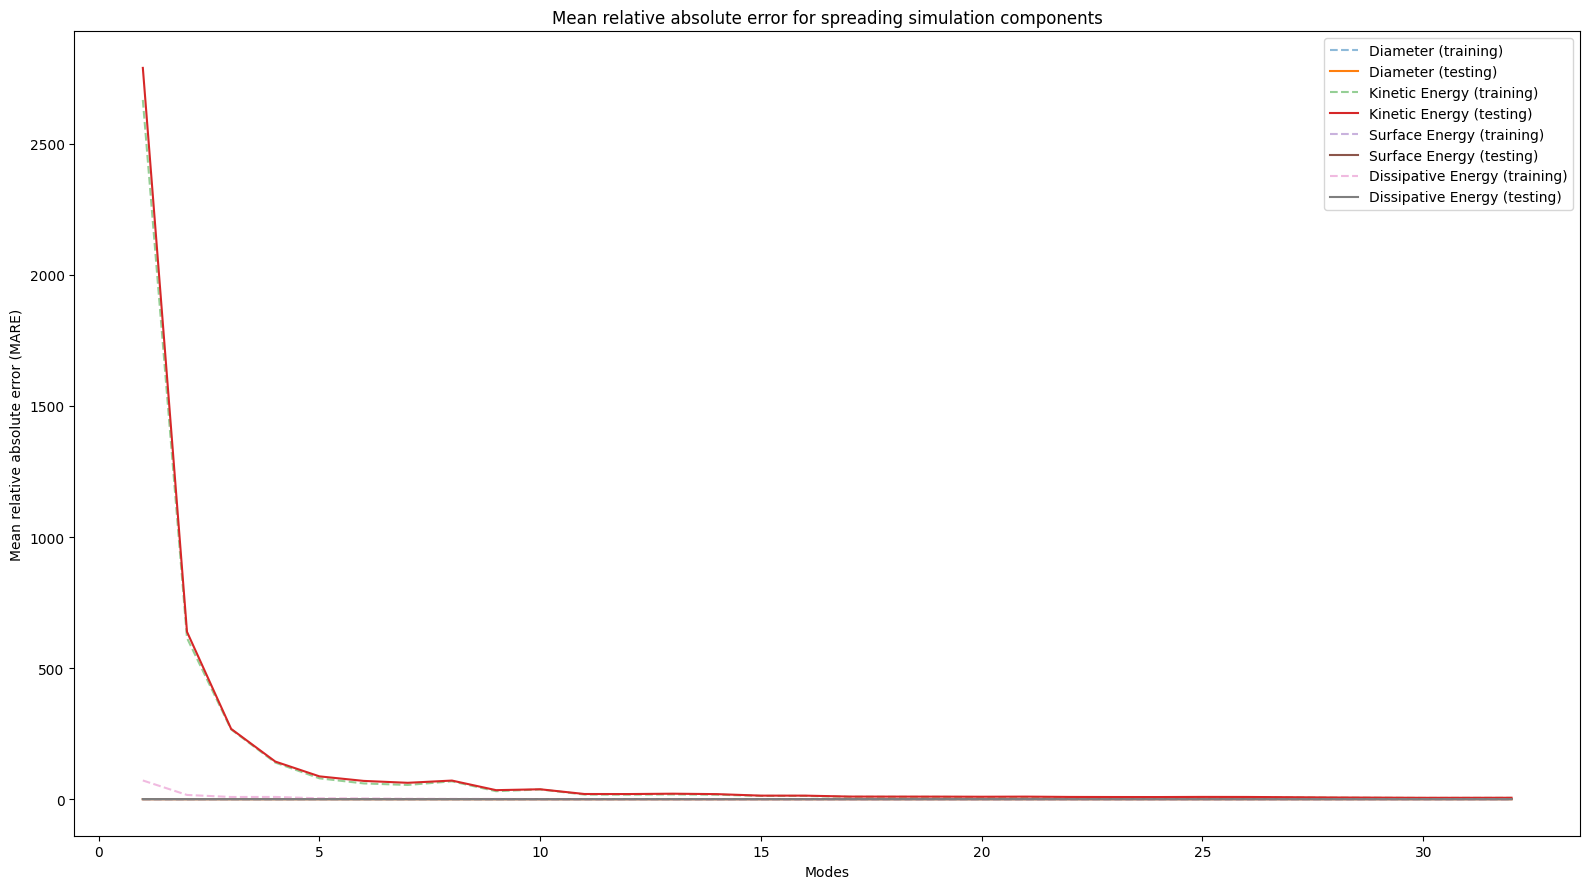

In [13]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Mean relative absolute error for spreading simulation components")
ax.set_xlabel("Number of modes")
ax.set_ylabel("Mean relative absolute error (MARE)")

for key, obj in spreading.items():
    obj['training_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='--', alpha=0.5)
    obj['testing_error'].loc[:, (slice(None), 'MRAE')].mean().unstack().plot(ax=ax, linestyle='-')

training_legend = [f"{key} (training)" for key in spreading.keys()]
testing_legend = [f"{key} (testing)" for key in spreading.keys()]
legend = [''] * (len(training_legend) + len(testing_legend))
legend[::2] = training_legend
legend[1::2] = testing_legend
ax.legend(legend)
fig.tight_layout()
fig.savefig(f".results/pca_error_modes_spreading.png", dpi=200)